# Comparing Black Marble Collection 1 and Collection 2 (5200)

This notebook demonstrates the usage of the `blackmarblepy` package with both Collection 1 and Collection 2 (VNP46A2.5200) data from the NASA Black Marble dataset. 

Note: Collection 2 requires special handling for grid names in the HDF5 files.

What is different in Collection-2?
- The data processing yields better data on a daily level
- Collection 2 often has improved stray light correction, better cloud masking, and updated calibration.



# Data Loading and Preprocessing

The following code loads the daily and monthly data extracts from their respective CSV files and performs initial processing.

Daily sum data loaded successfully
Monthly sum data loaded successfully


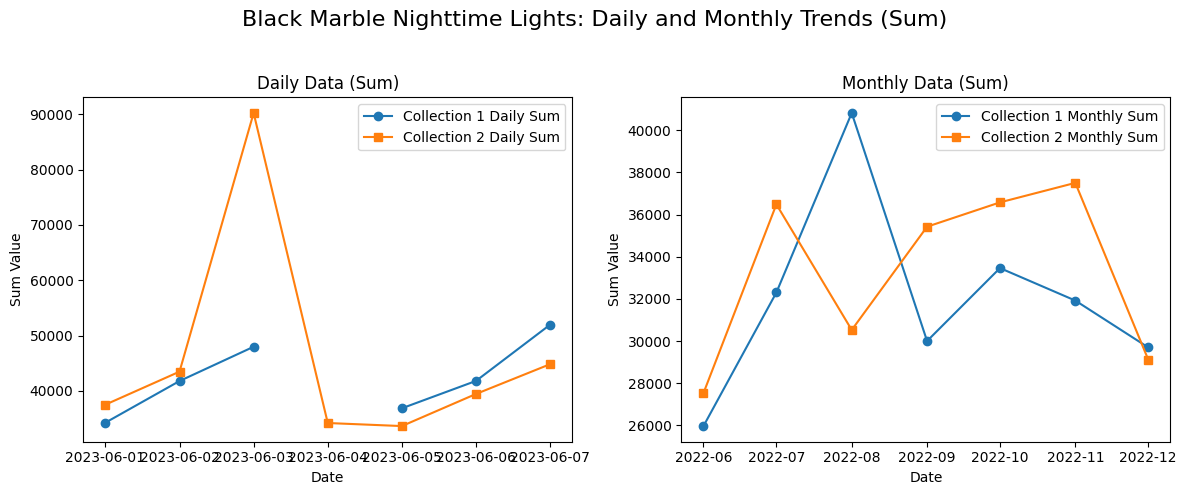

In [133]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Define output directories as in extraction script
base_dir = Path.home() / ".blackmarble_test"
COLLECTION1_DAILY_SUM = base_dir / "collection1" / "daily" / "daily_sum_result.csv"
COLLECTION2_DAILY_SUM = base_dir / "collection2" / "daily" / "daily_sum_result.csv"
COLLECTION1_MONTHLY_SUM = (
    base_dir / "collection1" / "monthly" / "monthly_sum_result.csv"
)
COLLECTION2_MONTHLY_SUM = (
    base_dir / "collection2" / "monthly" / "monthly_sum_result.csv"
)

# Load daily sum data
try:
    df_daily_sum1 = pd.read_csv(COLLECTION1_DAILY_SUM)
    df_daily_sum2 = pd.read_csv(COLLECTION2_DAILY_SUM)
    print("Daily sum data loaded successfully")
except Exception as e:
    print(f"Error loading daily sum data: {e}")

# Load monthly sum data
try:
    df_monthly_sum1 = pd.read_csv(COLLECTION1_MONTHLY_SUM)
    df_monthly_sum2 = pd.read_csv(COLLECTION2_MONTHLY_SUM)
    print("Monthly sum data loaded successfully")
except Exception as e:
    print(f"Error loading monthly sum data: {e}")


# Convert date columns if they exist with error check
def safe_to_datetime(df):
    if "date" in df.columns:
        try:
            df["date"] = pd.to_datetime(df["date"])
        except Exception as e:
            print(f"Error converting date column: {e}")


for df in [df_monthly_sum1, df_monthly_sum2, df_daily_sum1, df_daily_sum2]:
    safe_to_datetime(df)


# Self-iterating plotting function for robust error handling
def run_plots(attempt=1, max_attempts=3):
    try:
        plt.figure(figsize=(12, 5))
        plt.suptitle(
            "Black Marble Nighttime Lights: Daily and Monthly Trends (Sum)", fontsize=16
        )

        # Daily sum data comparison plot
        plt.subplot(1, 2, 1)
        if "date" in df_daily_sum1.columns and "ntl_sum" in df_daily_sum1.columns:
            plt.plot(
                df_daily_sum1["date"],
                df_daily_sum1["ntl_sum"],
                marker="o",
                label="Collection 1 Daily Sum",
            )
        if "date" in df_daily_sum2.columns and "ntl_sum" in df_daily_sum2.columns:
            plt.plot(
                df_daily_sum2["date"],
                df_daily_sum2["ntl_sum"],
                marker="s",
                label="Collection 2 Daily Sum",
            )
        plt.title("Daily Data (Sum)")
        plt.xlabel("Date")
        plt.ylabel("Sum Value")
        plt.legend()

        # Monthly sum data comparison plot
        plt.subplot(1, 2, 2)
        if "date" in df_monthly_sum1.columns and "ntl_sum" in df_monthly_sum1.columns:
            plt.plot(
                df_monthly_sum1["date"],
                df_monthly_sum1["ntl_sum"],
                marker="o",
                label="Collection 1 Monthly Sum",
            )
        if "date" in df_monthly_sum2.columns and "ntl_sum" in df_monthly_sum2.columns:
            plt.plot(
                df_monthly_sum2["date"],
                df_monthly_sum2["ntl_sum"],
                marker="s",
                label="Collection 2 Monthly Sum",
            )
        plt.title("Monthly Data (Sum)")
        plt.xlabel("Date")
        plt.ylabel("Sum Value")
        plt.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
    except Exception as e:
        print(f"Plot error on attempt {attempt}: {e}")
        if attempt < max_attempts:
            print("Retrying plotting...")
            run_plots(attempt + 1, max_attempts)
        else:
            print("Failed to plot after multiple attempts.")


# Call the plotting function
run_plots();

Collection 1 (merged): min=nan, max=nan, shape=(2400, 4800)
Collection 2 (merged): min=nan, max=nan, shape=(2400, 4800)
Shared color scale: vmin=nan, vmax=nan


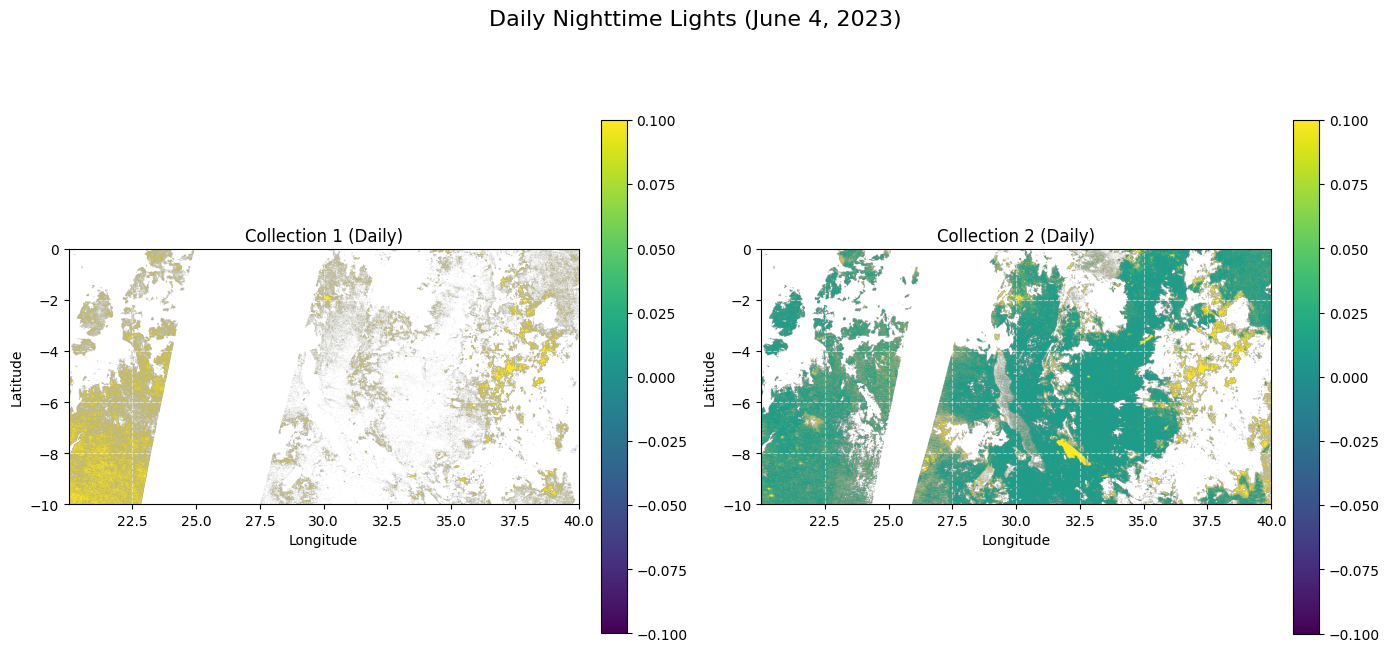

In [138]:
import rasterio
import numpy as np
import glob
from datetime import datetime
import geopandas as gpd
from rasterio.merge import merge

# Set the date of interest
plot_date = datetime(2023, 6, 3)
date_str = plot_date.strftime(
    "%Y%j"
)  # %j is day of year, e.g., 2023156 for June 5, 2023

# The file structure is VNP46A2.AYYYYDDD.hXXvYY.COLLECTION.TIMESTAMP
base_dir = Path.home() / ".blackmarble_test"
tif_pattern1 = str(base_dir / "collection1" / "daily" / f"*A{date_str}*.tif")
tif_pattern2 = str(base_dir / "collection2" / "daily" / f"*A{date_str}*.tif")

# Find the .tif files (could be more than one per day)
files1 = sorted(glob.glob(tif_pattern1))
files2 = sorted(glob.glob(tif_pattern2))


def mask_zero(img):
    masked = np.ma.masked_where(img == 0, img)
    return masked


def merge_tiles(file_list):
    srcs = [rasterio.open(f) for f in file_list]
    mosaic, out_trans = merge(srcs)
    crs = srcs[0].crs if srcs else None
    for src in srcs:
        src.close()
    return mosaic[0], out_trans, crs


# Load Rwanda boundary (assume data/boundaries/rwanda.geojson exists)
rwanda_path = Path("data/boundaries/rwanda.geojson")
if rwanda_path.exists():
    gdf_rwanda = gpd.read_file(rwanda_path)
else:
    gdf_rwanda = None

if files1 and files2:
    # Merge tiles for each collection
    img1_merged, trans1, crs1 = merge_tiles(files1)
    img2_merged, trans2, crs2 = merge_tiles(files2)
    img1_masked = mask_zero(img1_merged)
    img2_masked = mask_zero(img2_merged)
    # Compute global vmin/vmax for both images (ignoring masked values)
    all_data = np.ma.concatenate([img1_masked.compressed(), img2_masked.compressed()])
    vmin = all_data.min()
    vmax = all_data.max()
    print(
        f"Collection 1 (merged): min={img1_masked.min()}, max={img1_masked.max()}, shape={img1_masked.shape}"
    )
    print(
        f"Collection 2 (merged): min={img2_masked.min()}, max={img2_masked.max()}, shape={img2_masked.shape}"
    )
    print(f"Shared color scale: vmin={vmin}, vmax={vmax}")
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    fig.suptitle("Daily Nighttime Lights (June 4, 2023)", fontsize=16)
    for idx, (img, trans, crs, title, ax) in enumerate(
        [
            (img1_masked, trans1, crs1, "Collection 1 (Daily)", axes[0]),
            (img2_masked, trans2, crs2, "Collection 2 (Daily)", axes[1]),
        ]
    ):
        bounds = rasterio.transform.array_bounds(img.shape[0], img.shape[1], trans)
        extent = [
            bounds[0],
            bounds[2],
            bounds[1],
            bounds[3],
        ]  # [left, right, bottom, top]
        im = ax.imshow(
            img, cmap="viridis", extent=extent, origin="upper", vmin=vmin, vmax=vmax
        )
        ax.set_title(title)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        ax.grid(True, color="white", linestyle="--", alpha=0.5)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        # Overlay Rwanda boundary if available, after the raster
        if gdf_rwanda is not None:
            gdf_rwanda_plot = gdf_rwanda.copy()
            if gdf_rwanda_plot.crs != crs:
                gdf_rwanda_plot = gdf_rwanda_plot.to_crs(crs)
            gdf_rwanda_plot.boundary.plot(
                ax=ax, edgecolor="red", linewidth=2, zorder=20
            )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print(
        f"No .tif file found for {plot_date.strftime('%Y-%m-%d')} in one or both collections."
    )

Collection 1 (monthly, merged): min=nan, max=nan, shape=(2400, 4800)
Collection 2 (monthly, merged): min=nan, max=nan, shape=(2400, 4800)
Shared color scale: vmin=nan, vmax=nan


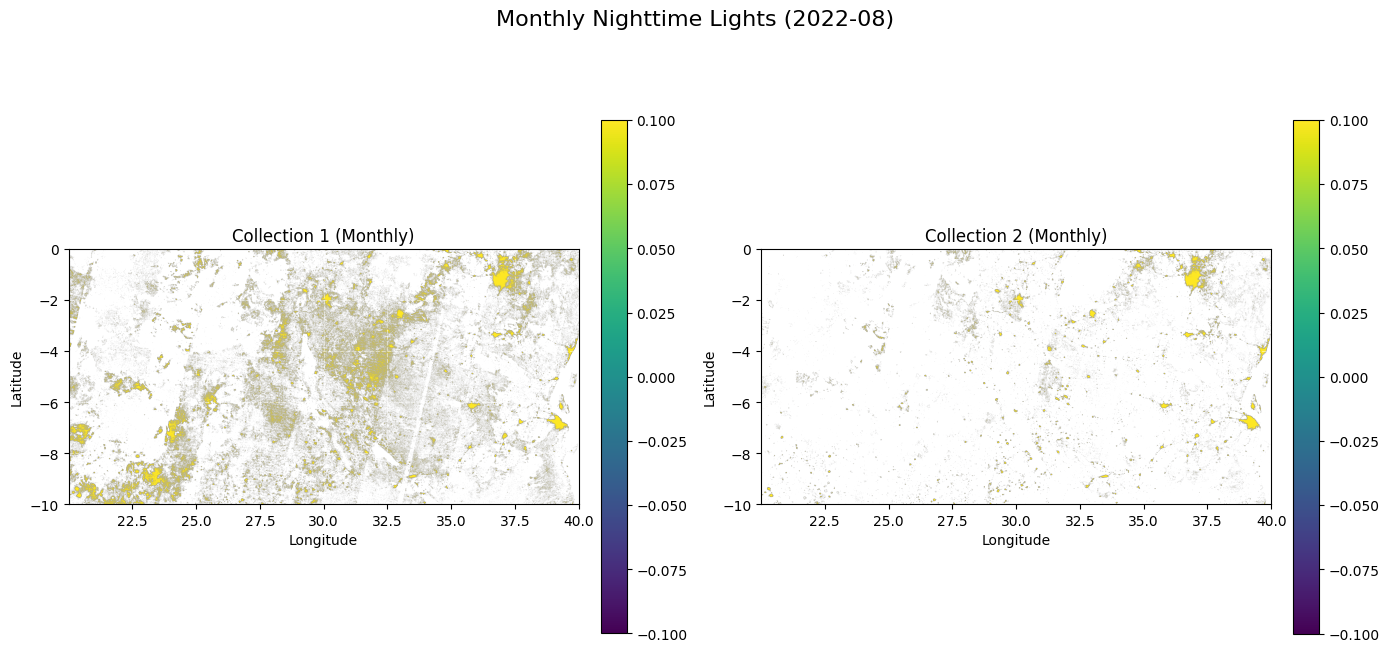

In [150]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import glob
from datetime import datetime
import geopandas as gpd
from pathlib import Path
import re

# Set the month of interest (August 2022)
plot_month = datetime(2022, 8, 1)
month_str = plot_month.strftime("%Y%m")  # e.g., 202208

# The file structure is VNP46A3.AYYYYDDD.hXXvYY.COLLECTION.TIMESTAMP for monthly
base_dir = Path.home() / ".blackmarble_test"
monthly_dir1 = base_dir / "collection1" / "monthly"
monthly_dir2 = base_dir / "collection2" / "monthly"

# List all .tif files in the monthly folders
all_tifs1 = sorted(glob.glob(str(monthly_dir1 / "*.tif")))
all_tifs2 = sorted(glob.glob(str(monthly_dir2 / "*.tif")))


# Helper to extract date from filename (e.g., VNP46A3.A2022244.h20v09.001.2022285015929)
def extract_date_from_filename(filename):
    match = re.search(r"A(\d{7})", filename)
    if match:
        yyyyddd = match.group(1)
        dt = datetime.strptime(yyyyddd, "%Y%j")
        return dt.strftime("%Y-%m")
    return None


# Pick all tifs matching the month of interest
def filter_tifs_by_month(tif_list, month_str):
    selected = []
    for f in tif_list:
        date_str = extract_date_from_filename(f)
        if date_str == plot_month.strftime("%Y-%m"):
            selected.append(f)
    return selected


files1 = filter_tifs_by_month(all_tifs1, month_str)
files2 = filter_tifs_by_month(all_tifs2, month_str)


def mask_zero(img):
    masked = np.ma.masked_where(img == 0, img)
    return masked


def merge_tiles(file_list):
    srcs = [rasterio.open(f) for f in file_list]
    mosaic, out_trans = merge(srcs)
    crs = srcs[0].crs if srcs else None
    for src in srcs:
        src.close()
    return mosaic[0], out_trans, crs


# Load Rwanda boundary (assume data/boundaries/rwanda.geojson exists)
rwanda_path = Path("data/boundaries/rwanda.geojson")
if rwanda_path.exists():
    gdf_rwanda = gpd.read_file(rwanda_path)
else:
    gdf_rwanda = None

if files1 and files2:
    # Merge tiles for each collection
    img1_merged, trans1, crs1 = merge_tiles(files1)
    img2_merged, trans2, crs2 = merge_tiles(files2)
    img1_masked = mask_zero(img1_merged)
    img2_masked = mask_zero(img2_merged)
    # Compute global vmin/vmax for both images (ignoring masked values)
    all_data = np.ma.concatenate([img1_masked.compressed(), img2_masked.compressed()])
    vmin = all_data.min()
    vmax = all_data.max()

    # Extract date from first file (if available) for labeling
    date_label = extract_date_from_filename(files1[0]) if files1 else month_str

    print(
        f"Collection 1 (monthly, merged): min={img1_masked.min()}, max={img1_masked.max()}, shape={img1_masked.shape}"
    )
    print(
        f"Collection 2 (monthly, merged): min={img2_masked.min()}, max={img2_masked.max()}, shape={img2_masked.shape}"
    )
    print(f"Shared color scale: vmin={vmin}, vmax={vmax}")
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    fig.suptitle(f"Monthly Nighttime Lights ({date_label})", fontsize=16)
    for idx, (img, trans, crs, title, ax) in enumerate(
        [
            (img1_masked, trans1, crs1, "Collection 1 (Monthly)", axes[0]),
            (img2_masked, trans2, crs2, "Collection 2 (Monthly)", axes[1]),
        ]
    ):
        bounds = rasterio.transform.array_bounds(img.shape[0], img.shape[1], trans)
        extent = [
            bounds[0],
            bounds[2],
            bounds[1],
            bounds[3],
        ]  # [left, right, bottom, top]
        im = ax.imshow(
            img, cmap="viridis", extent=extent, origin="upper", vmin=vmin, vmax=vmax
        )
        ax.set_title(title)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        ax.grid(True, color="white", linestyle="--", alpha=0.5)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        # Overlay Rwanda boundary if available, after the raster
        if gdf_rwanda is not None:
            gdf_rwanda_plot = gdf_rwanda.copy()
            if gdf_rwanda_plot.crs != crs:
                gdf_rwanda_plot = gdf_rwanda_plot.to_crs(crs)
            gdf_rwanda_plot.boundary.plot(
                ax=ax, edgecolor="red", linewidth=2, zorder=20
            )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print(
        f"No monthly .tif file found for {plot_month.strftime('%Y-%m')} in one or both collections."
    )


--- High-level Summary ---
Collection 1 Daily: count=14, min=0.10, max=2117.30, mean=0.54, median=0.36, std=2.49
Collection 2 Daily: count=14, min=0.00, max=13592.75, mean=0.36, median=0.01, std=4.02
Collection 1 Monthly: count=14, min=0.50, max=1369.80, mean=1.22, median=0.58, std=3.76
Collection 2 Monthly: count=14, min=0.00, max=9524.29, mean=2.30, median=0.70, std=14.64


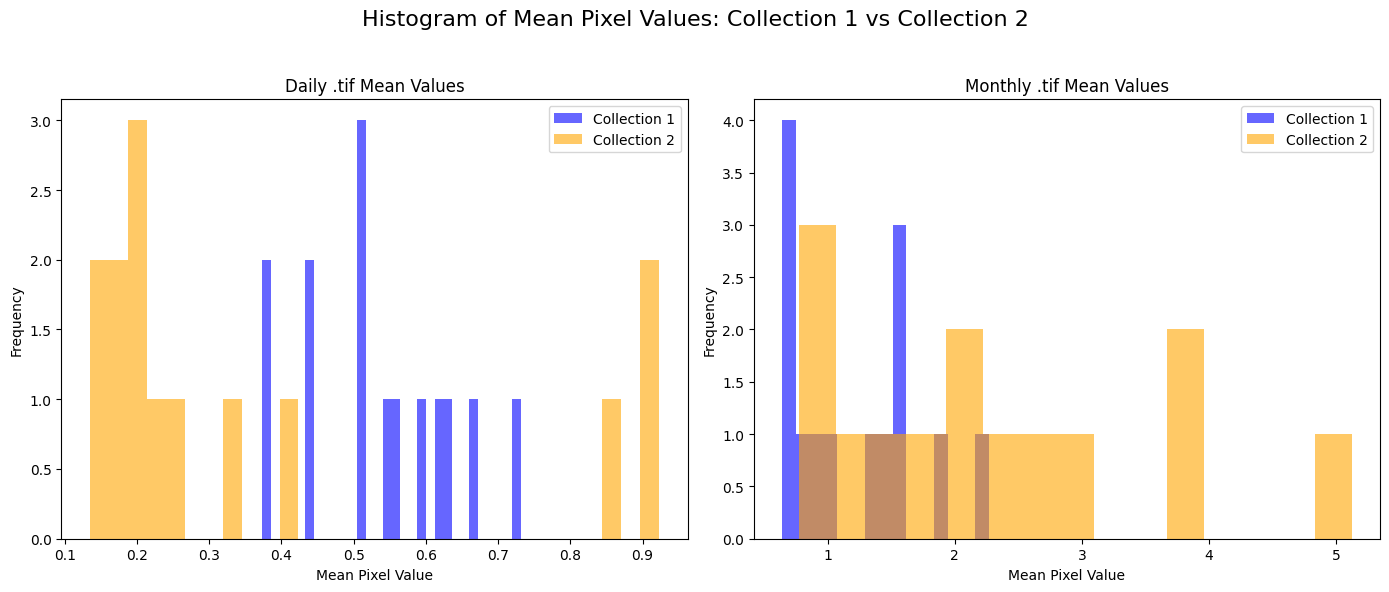

In [155]:
# High-level summary and histogram comparison of all .tif files in monthly and daily folders for collection-1 and collection-2
import rasterio
import numpy as np
import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


def summarize_tif_set(tif_files):
    stats = []
    for f in tif_files:
        try:
            with rasterio.open(f) as src:
                arr = src.read(1)
                masked = np.ma.masked_where((arr == 0) | np.isnan(arr), arr)
                # Only include if there is at least one valid (unmasked) value
                if masked.count() > 0:
                    stats.append(
                        {
                            "file": Path(f).name,
                            "min": float(masked.min()),
                            "max": float(masked.max()),
                            "mean": float(masked.mean()),
                            "median": float(np.ma.median(masked)),
                            "std": float(masked.std()),
                            "nonzero_count": int(np.sum(masked != 0)),
                            "total_count": int(masked.size),
                            "nan_count": int(np.sum(np.isnan(masked))),
                        }
                    )
                else:
                    stats.append(
                        {"file": Path(f).name, "error": "All values masked or NaN"}
                    )
        except Exception as e:
            stats.append({"file": Path(f).name, "error": str(e)})
    df = pd.DataFrame(stats)
    # Remove rows with error for numeric analysis
    if "error" in df.columns:
        df = df[df["error"].isna() | (df["error"].isnull())]
        df = df.drop(columns=["error"], errors="ignore")
    return df


base_dir = Path.home() / ".blackmarble_test"
folders = {
    "collection1_daily": base_dir / "collection1" / "daily",
    "collection2_daily": base_dir / "collection2" / "daily",
    "collection1_monthly": base_dir / "collection1" / "monthly",
    "collection2_monthly": base_dir / "collection2" / "monthly",
}

results = {}
for key, folder in folders.items():
    tif_files = sorted(glob.glob(str(folder / "*.tif")))
    results[key] = summarize_tif_set(tif_files)


# High-level summary statistics
def high_level_summary(df, label):
    if df.empty or not set(["min", "max", "mean", "median", "std"]).issubset(
        df.columns
    ):
        return f"{label}: No valid data"
    return (
        f"{label}: count={len(df)}, min={df['min'].min():.2f}, max={df['max'].max():.2f}, "
        f"mean={df['mean'].mean():.2f}, median={df['median'].mean():.2f}, std={df['std'].mean():.2f}"
    )


print("\n--- High-level Summary ---")
print(high_level_summary(results["collection1_daily"], "Collection 1 Daily"))
print(high_level_summary(results["collection2_daily"], "Collection 2 Daily"))
print(high_level_summary(results["collection1_monthly"], "Collection 1 Monthly"))
print(high_level_summary(results["collection2_monthly"], "Collection 2 Monthly"))

# Plot histograms comparing mean values for daily and monthly data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(
    "Histogram of Mean Pixel Values: Collection 1 vs Collection 2", fontsize=16
)

# Daily
ax = axes[0]
for label, color, key in [
    ("Collection 1", "blue", "collection1_daily"),
    ("Collection 2", "orange", "collection2_daily"),
]:
    df = results[key]
    if not df.empty and "mean" in df.columns and df["mean"].notna().any():
        ax.hist(df["mean"].dropna(), bins=30, alpha=0.6, label=label, color=color)
ax.set_title("Daily .tif Mean Values")
ax.set_xlabel("Mean Pixel Value")
ax.set_ylabel("Frequency")
ax.legend()

# Monthly
ax = axes[1]
for label, color, key in [
    ("Collection 1", "blue", "collection1_monthly"),
    ("Collection 2", "orange", "collection2_monthly"),
]:
    df = results[key]
    if not df.empty and "mean" in df.columns and df["mean"].notna().any():
        ax.hist(df["mean"].dropna(), bins=15, alpha=0.6, label=label, color=color)
ax.set_title("Monthly .tif Mean Values")
ax.set_xlabel("Mean Pixel Value")
ax.set_ylabel("Frequency")
ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()